In [1]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import trange,tqdm
sys.path.append('./include')
import ml4s
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s._set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import copy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime

from sklearn.linear_model import LogisticRegression

# Problem 3

# a.)

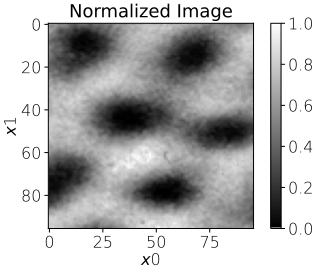

In [52]:
data = plt.imread("mcm41_reduced.png")

max_value = float(data.max())

x0_dim, x1_dim = data.shape

for i in range(x0_dim):
    for j in range(x1_dim):
        data[i, j] = data[i, j] / max_value

plt.imshow(data, cmap = 'gray')
plt.colorbar()
plt.title("Normalized Image")
plt.xlabel(r'$x0$')
plt.ylabel(r'$x1$')
plt.show()

# b.)

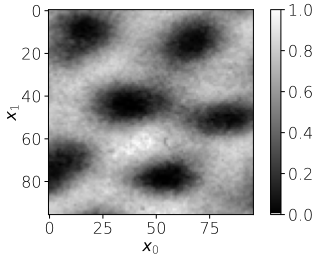

In [53]:
def target_func(x0, x1):
    x0_int = np.floor(x0*x0_dim*0.9999).astype(int)
    x1_int = np.floor(x1*x1_dim*0.9999).astype(int)
    return data[x0_int, x1_int]

grid_size = 96

# The domain over which you want to plot [xmin,xmax,ymin,ymax]
extent = [0, 1, 0, 1]

X = np.meshgrid(np.linspace(extent[0],extent[1],grid_size,dtype=float),
                np.linspace(extent[2],extent[3],grid_size,dtype=float),
               indexing='ij')

batch_size = grid_size**2

aₒ = np.zeros([batch_size,2])
aₒ[:,0] = X[0].flatten()
aₒ[:,1] = X[1].flatten()

# Evaluate your function here
# note that *X unpacks the list (https://docs.python.org/3.7/tutorial/controlflow.html#unpacking-argument-lists)
result = target_func(*X)

plt.imshow(result,cmap='gray')
plt.colorbar()
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$');

# c.)

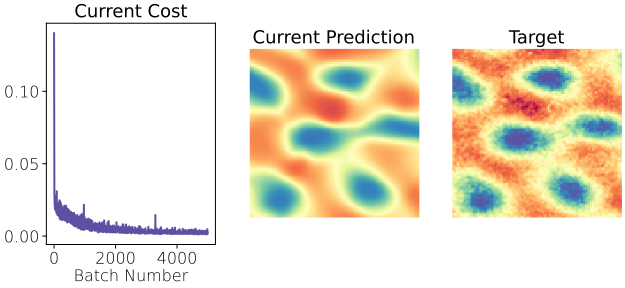

In [54]:
def feed_forward(aₒ,w,b):
    '''Propagate an input vector x = aₒ through 
       a network with weights (w) and biases (b).
       Return: activations (a) and derivatives f'(z).'''
    
    a,df = [aₒ],[]
    for wℓ,bℓ in zip(w,b):
        zℓ = np.dot(a[-1],wℓ) + bℓ
        _a,_df = ffprime(zℓ)
        a.append(_a)
        df.append(_df)
        
    return a,df

def backpropagation(y,a,w,b,df): 
    '''Inputs: results of a forward pass
       Targets     y: dim(y)  = batch_size ⨯ nL
       Activations a: dim(a)  = L ⨯ batch_size ⨯ nℓ
       Weights     w: dim(w)  = L-1 ⨯ nℓ₋₁ ⨯ nℓ
       Biases      b: dim(b)  = L-1 ⨯ nℓ
       f'(z)      df: dim(df) = L-1 ⨯ batch_size ⨯ nℓ
       
       Outputs: returns mini-batch averaged gradients of the cost function w.r.t. w and b
       dC_dw: dim(dC_dw) = dim(w)
       dC_db: dim(dC_db) = dim(b)
    '''
    
    num_layers = len(w)
    L = num_layers-1        
    batch_size = len(y)
    
    # initialize empty lists to store the derivatives of the cost functions
    dC_dw = [None]*num_layers
    dC_db = [None]*num_layers
    Δ = [None]*num_layers
    
    # perform the backpropagation
    for ℓ in reversed(range(num_layers)):
        
        # treat the last layer differently
        if ℓ == L:
            Δ[ℓ] = (a[ℓ] - y)*df[ℓ]
        else: 
            Δ[ℓ] = (Δ[ℓ+1] @ w[ℓ+1].T) * df[ℓ]
            
        dC_dw[ℓ] = (a[ℓ-1].T @ Δ[ℓ]) / batch_size
        dC_db[ℓ] = np.average(Δ[ℓ],axis=0)
        
    return dC_dw,dC_db

def gradient_step(η,w,b,dC_dw,dC_db):
    '''Update the weights and biases as per gradient descent.'''
    
    for ℓ in range(len(w)):
        w[ℓ] -= η*dC_dw[ℓ]
        b[ℓ] -= η*dC_db[ℓ]
    return w,b

def train_network(x,y,w,b,η):
    '''Train a deep neural network via feed forward and back propagation.
       Inputs:
       Input         x: dim(x) = batch_size ⨯ n₁
       Target        y: dim(y) = batch_size ⨯ nL
       Weights       w: dim(w)  = L-1 ⨯ nℓ₋₁ ⨯ nℓ
       Biases        b: dim(b)  = L-1 ⨯ nℓ
       Learning rate η
       
       Outputs: the least squared cost between the network output and the targets.
       '''
    
    a,df = feed_forward(x,w,b)
    
    # we pass a cycled a by 1 layer for ease of indexing
    dC_dw,dC_db = backpropagation(y,a[1:]+[a[0]],w,b,df)
    
    w,b = gradient_step(η,w,b,dC_dw,dC_db)
    
    return 0.5*np.average((y-a[-1])**2)

def make_batch(n,batch_size,extent,func):
    '''Create a mini-batch from our inputs and outputs.
    Inputs:
    n0        : number of neurons in each layer
    batch_size: the desired number of samples in the mini-batch
    extent    : [min(xₒ),max(xₒ), min(x₁),max(x₁),…,min(x_{n[0]-1}),max(x_{n[0]-1})]
    func:     : the desired target function.
    
    Outputs: returns the desired mini-batch of inputs and targets.
    '''
    
    x = np.zeros([batch_size,n[0]])
    for i in range(n[0]):
        x[:,i] = np.random.uniform(low=extent[2*i],high=extent[2*i+1],size=[batch_size])

    y = func(*[x[:,j] for j in range(n[0])]).reshape(-1,n[-1])
    
    return x,y

n = [2,200,100,50,20,10,1]
w,b = [],[]
for ℓ in range(len(n)-1):
    w.append(np.random.uniform(low=-3,high=3,size=(n[ℓ],n[ℓ+1])))
    b.append(np.random.uniform(low=-3,high=3, size=n[ℓ+1]))
    
def ffprime(z): 
    '''calculate f(z) and f'(z); sigmoid.'''
    _f = 1.0/(1.0+np.exp(-z))
    return _f,np.exp(-z)*(_f**2)

from IPython.display import clear_output,display
from time import sleep
η = 2.1

batch_size = 400
num_steps = 5000
plot_ratio = int(num_steps / 50)

costs = np.zeros(num_steps)
for j in range(num_steps):
    
    x,y = make_batch(n,batch_size,extent,target_func)
    costs[j] = train_network(x,y,w,b,η)
    
    # we plot every plot_ratio steps
    if not j % plot_ratio or j == num_steps-1:
        
        clear_output(wait=True)
        ret = feed_forward(aₒ,w,b)
        aL = ret[0][-1].reshape(grid_size,grid_size)
        fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(10,4))
        
        ax[1].axis('off')
        img = ax[1].imshow(aL, extent=extent, cmap='Spectral_r', rasterized=True, 
               interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)
        
        ax[2].axis('off')
        ax[2].imshow(target_func(*X), extent=extent, cmap='Spectral_r', rasterized=True, 
           interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

        ax[0].plot(costs)

        ax[0].set_title("Current Cost")
        ax[0].set_xlabel("Batch Number")
        ax[1].set_title("Current Prediction")
        ax[2].set_title("Target")

        plt.show()

import json

file = "3c_results.json"

final_results = {
    "Topology": n,
    "Eta": η,
    "Batch Size": batch_size
}

with open(file, "w") as outfile:
    json.dump(final_results, outfile, indent=1)

# d.)

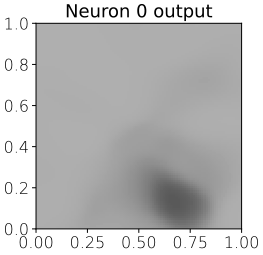

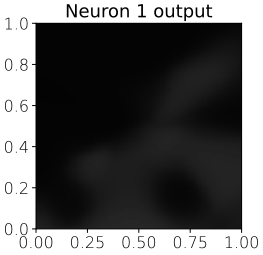

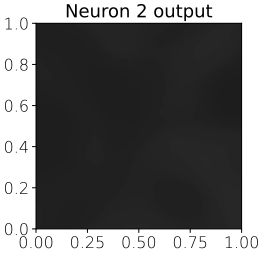

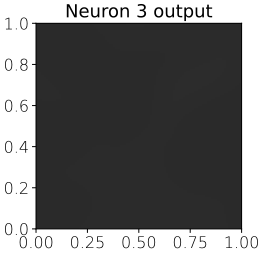

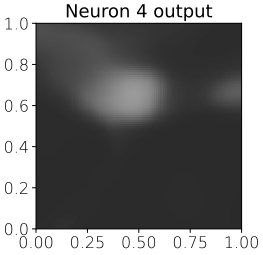

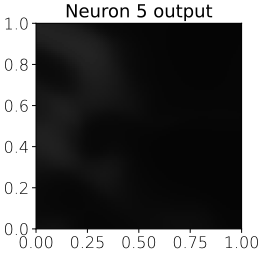

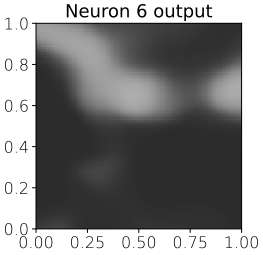

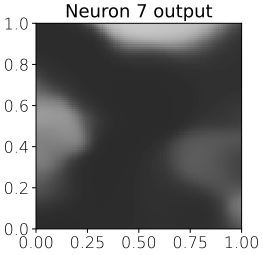

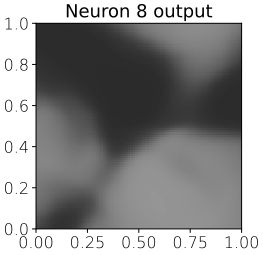

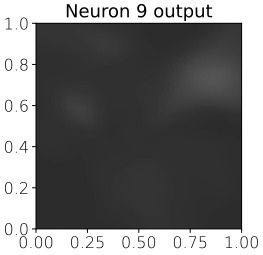

It appears that most neurons are not capturing much structure, and most of the final structure is present in only a few neurons in the final hidden layer.


In [56]:
for n in range(len(w[-1])):

    w_mod = copy.deepcopy(w)

    for i in range(len(w_mod[-1])):
        if (i != n):
            w_mod[-1][i] = 0


    ret = feed_forward(aₒ,w_mod,b)
    aL = ret[0][-1].reshape(grid_size,grid_size)
    plt.title(f'Neuron {n} output')
    plt.imshow(aL, extent=extent, cmap='gray', rasterized=True, 
                interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)
    plt.show()

print("It appears that most neurons are not capturing much structure, "
      "and most of the final structure is present in only a few neurons in the final hidden layer.")

# Problem 4

# a.)

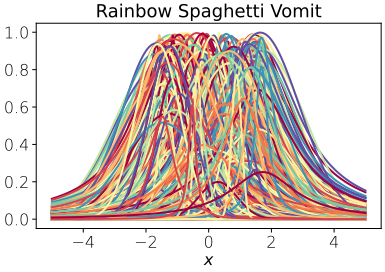

In [8]:
def N(A, μ, σ, x):
    return A * np.exp(-((x - μ)**2) / (2 * σ**2))

def L(A, μ, σ, x):
    return A / (((x - μ) / σ)**2 + 1)

x_range = np.linspace(-5, 5, 1000)

num_curves = 1000

curve_data = []

labels = []

for i in range(num_curves):
    r = np.random.choice([0, 1])
    
    A = np.random.uniform(0, 1)
    
    μ = np.random.uniform(-1.75, 1.75)
    
    σ = np.random.uniform(.1, 1.5)
    
    if (r == 0):
        curve = N(A, μ, σ, x_range)
              
        labels.append(0)
        
    else:
        curve = L(A, μ, σ, x_range)
                
        labels.append(1)
    
    curve_data.append(list(curve))
    
    plt.plot(x_range, curve)

plt.title("Rainbow Spaghetti Vomit")   #Just a little joke
plt.xlabel(r'$x$')
plt.show()

# b.)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                10010     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 10,071
Trainable params: 10,071
Non-trainable params: 0
_________________________________________________________________
4/4 - 0s - loss: 0.1184 - accuracy: 0.9900


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Num. Mistakes  = 8
Accuracy sharply increases as you increase the number of functions available to train with. Model goes from making mistakes about 10% of the time for 10 functions to making mistakes about 5% of the time for 100 functions to making mistakes about 0.5% of the time for 1000 functions Also, with 100 functions, the training loss was much lower than the testing loss, indicating overfitting.


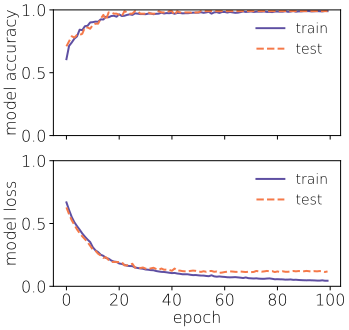

In [3]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(curve_data, labels, test_size=0.1)

model = keras.Sequential(
[
    layers.Dense(10, input_shape=(len(x_range),), activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy']) 

batch_size = num_curves**2
epochs = 100

training_history = {}
training_history['test'] = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test,y_test), verbose=0)

# look into training history
fig,ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(5,5))

# summarize history for accuracy
ax[0].plot(training_history['test'].history['accuracy'])
ax[0].plot(training_history['test'].history['val_accuracy'], ls='--', color=colors[-3])
ax[0].set_ylabel('model accuracy')
ax[0].legend(['train', 'test'], loc='best')
ax[0].set_ylim(0,1)

# summarize history for loss
ax[1].plot(training_history['test'].history['loss'])
ax[1].plot(training_history['test'].history['val_loss'], ls='--', color=colors[-3])
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='best');

# evaluate model
score = model.evaluate(x_test, y_test, verbose=2)

curve_data = np.array(curve_data)

predictions = np.zeros(curve_data.shape[0],dtype=int)
predictions[np.where(model(curve_data)>=0.5)[0]] = 1

mistakes = np.where(labels != predictions)[0]
num_mistakes = len(mistakes)

print(f'Num. Mistakes  = {num_mistakes}')

print("Accuracy sharply increases as you increase the number of functions available to train with. "
      "Model goes from making mistakes about 10% of the time for 10 functions "
      "to making mistakes about 5% of the time for 100 functions "
      "to making mistakes about 0.5% of the time for 1000 functions "
      "Also, with 100 functions, the training loss was much lower than the testing loss, indicating overfitting."
     )

# c.)

In [4]:
logreg = LogisticRegression(C=1e5, max_iter=10000)

logreg.fit(curve_data, labels)

performance = logreg.score(curve_data, labels)

print("Performance of logistic regression:", performance)

print("Performance of neural network and logistic regression are very similar.")

Performance of logistic regression: 0.996
Performance of neural network and logistic regression are very similar.


# Problem 5

For my final project, I would like to do a classification problem related to my future research, suggested to me by my (all but certain) future advisor Professor Efremenko. In this project, I would be considering a PEN scintillator detecting both neutrons and electrons. These different particles trigger different detection curves from the scintillator, i.e., the time distribution of light intensity of light pulses from the scintillator triggered by heavier or lighter particles will be wider or narrower or have different characteristic shapes such as longer tails. Similarly to problem four in this homework, I would then be writing a neural network algorithm to classify these detection curves as coming from either a neutron or an electron.

This project does seem perhaps a bit too similar to problem four in this homework, but I am not sure how similar it will actually be once we get into the details, such as how these detection curves are encoded in the program. But also, I quite like that this project is at least wholistically similar to something I have already done, as I am still struggling quite a bit with actually writing machine learning algorithms. Working with something familiar will help me get started on it, and we can always expand beyond the original premise if the project turns out to be too limited.

References:

https://www.sciencedirect.com/science/article/abs/pii/0029554X71900541

https://www.sciencedirect.com/science/article/abs/pii/S0168900211019036